In [169]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from popsycle import synthetic
from astropy.table import Table
from params import mock_roman_params

import copy

%reload_ext autoreload
%autoreload 2

## Modify compact object dictionary with FFPs

In [157]:
def sample_ffp_mass(N_ffps: int) -> np.ndarray:
    '''
    This is a dummy function currently. Will want to sample some distribution of masses for the ffps.
    For now, return an array of length N_ffps with fixed mass value in units of solar masses
    '''

    #Jupiter is about 1e-3 solar masses
    # return np.ones(N_ffps) * 1e-3
    return np.ones(N_ffps) * 1

def set_ffp_masses(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite the masses of the ffps.
    '''
    N_objects = ffp_arr.shape[0]
    masses = sample_ffp_mass(N_objects)
    ffp_arr['mass'] = masses
    #PopSyCLE sets Zero age main sequence mass,zams_mass, equal to mass for PBHs. 
    #Following this convention for ffps
    ffp_arr['zams_mass'] = masses


def set_ffp_photometry(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite the photometry of the ffps.
    '''
    N_objects = ffp_arr.shape[0]
    photometry_ffps = np.zeros(N_objects)

    ffp_arr['ubv_J'] = photometry_ffps
    ffp_arr['ubv_H'] = photometry_ffps
    ffp_arr['ubv_K'] = photometry_ffps
    ffp_arr['ubv_U'] = photometry_ffps
    ffp_arr['ubv_I'] = photometry_ffps
    ffp_arr['ubv_B'] = photometry_ffps
    ffp_arr['ubv_V'] = photometry_ffps
    ffp_arr['ubv_R'] = photometry_ffps

def set_ffp_rem_id(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite the remnant id of the ffps.
    '''
    N_objects = ffp_arr.shape[0]
    #pbhs are highest remnant id implemented in popsycle so far so set ffps to 105
    rem_ids = np.ones(N_objects) * 105
    ffp_arr['rem_id'] = rem_ids

def set_ffp_pop_id(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite the pop id of the ffps.
    Set it to 10 since this is what is done for PBHs
    '''
    N_objects = ffp_arr.shape[0]
    #Population ID (e.g. Disk, Halo, Bulge. See https://galaxia.sourceforge.net/Galaxia3pub.html for details) 'popid'.
    pop_ids = np.ones(N_objects) * 10

def set_ffp_misc(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite some miscilanious attributes of the ffps
    that are not relevant for us. Set them to NaNs (this is what is done for PBHs I believe)
    '''

    # Bolometric magnitude: mbol, 
    # Surface gravity: grav,
    # Metalicity: feh,
    # log(age/yr): 'age',
    # Effective temperature: teff
    # Galactic Extinsion 'exbv'

    N_objects = ffp_arr.shape[0]
    misc_ffps_nans = np.full(N_objects, np.NaN)
   
    ffp_arr['mbol'] = misc_ffps_nans
    ffp_arr['grav'] = misc_ffps_nans
    ffp_arr['feh'] = misc_ffps_nans
    ffp_arr['age'] = misc_ffps_nans
    ffp_arr['teff'] = misc_ffps_nans
    ffp_arr['exbv'] = misc_ffps_nans

def set_ffp_positions(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite the positions of the ffps.
    # For now, just perturb the positions of the FFPs by a small amount
    '''

    noise_rad = np.random.normal(0, np.std(ffp_arr['rad']*.1), len(ffp_arr['rad']))
    noise_glat = np.random.normal(0, np.std(ffp_arr['glat']*.1), len(ffp_arr['glat']))
    noise_glon = np.random.normal(0, np.std(ffp_arr['glon']*.1), len(ffp_arr['glon']))

    ffp_arr['rad'] = ffp_arr['rad'] + noise_rad
    ffp_arr['glat']  = ffp_arr['glat'] + noise_glat
    ffp_arr['glon']= ffp_arr['glon'] + noise_glon

    position_helio = synthetic.galactic_to_heliocentric(
                ffp_arr['rad'], ffp_arr['glat'], ffp_arr['glon']
            )
    ffp_arr['px'], ffp_arr['py'], ffp_arr['pz'] = position_helio

def inject_ffp_params(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input numpy array to overwrite all relevant parameters for ffps
    '''
    set_ffp_masses(ffp_arr)
    set_ffp_photometry(ffp_arr)
    set_ffp_rem_id(ffp_arr)
    set_ffp_misc(ffp_arr)
    set_ffp_pop_id(ffp_arr)
    set_ffp_positions(ffp_arr)

    #todo
    #Heliocentric velocities (in km/s): 'vx', 'vy', 'vz',
    #Radial velocity and proper motions: 'vr', 'mu_b', 'mu_lcosb'
    # Object number within given bin: obj_id - Don't think we care about this but should revisit later - obj_id



In [158]:
def inject_ffps(hdf5_file: str = 'generated_files/example_ffp_copy.h5', output_hdf5_file: str = 'generated_files/modified_ffp.h5') -> None:
    '''
    Injects ffps into the hdf5 file and saves the new hdf5 file
    '''

    no_ffp_hdf5_file = h5py.File(hdf5_file, "r")
    ffp_hdf5_file = h5py.File(output_hdf5_file, "w")

    #these keys don't contain stars so ignore them in the loop creating the df
    ignored_keys = {'add_pbh', 'lat_bin_edges', 'long_bin_edges'}
    key_list = list(no_ffp_hdf5_file)
    key_list = [key for key in key_list if key not in ignored_keys]

    hdf5_dset_names = no_ffp_hdf5_file[key_list[0]][:].dtype.names
    comp_dtype = synthetic._generate_comp_dtype(hdf5_dset_names)

    #If we want to compare to no pbhs, set this to false and use non-pbh h5 as 'hdf5_file'
    ffp_hdf5_file["add_pbh"] = True

    lat_bin = no_ffp_hdf5_file["lat_bin_edges"][:]
    long_bin = no_ffp_hdf5_file["long_bin_edges"][:]

    for idx, key in enumerate(key_list):
        key_data = no_ffp_hdf5_file[key][:]
        #copy the stars in this bin (assuming 1 ffp per star implicitly)
        ffp_data_in_key = copy.deepcopy(key_data)
        #modify the copy to use the ffp params
        inject_ffp_params(ffp_data_in_key)
        combined_data = np.hstack((key_data, ffp_data_in_key))
        # cant use combined data for now because it complains about duplicate postions (l, b)
        # which messes up a nearest neighbors search
        # combined_data = ffp_data_in_key

        _ = ffp_hdf5_file.create_dataset(
            key, shape=(combined_data.shape[0],), dtype=comp_dtype, data=combined_data
        )
        
    _ = ffp_hdf5_file.create_dataset("lat_bin_edges", (len(lat_bin), 1), data=lat_bin)
    _ = ffp_hdf5_file.create_dataset("long_bin_edges", (len(lat_bin), 1), data=long_bin)

    no_ffp_hdf5_file.close()
    ffp_hdf5_file.close()


In [159]:
inject_ffps()

In [160]:
file_path = 'generated_files/modified_ffp.h5'
with h5py.File(file_path, 'r') as f:
    print(f.keys())
    dat2 = np.array(f['l0b0'])

<KeysViewHDF5 ['add_pbh', 'l0b0', 'l0b1', 'l1b0', 'l1b1', 'lat_bin_edges', 'long_bin_edges']>


### Now let's try and calculate events for this new population file

In [161]:
#Set to Roman Params from paper
synthetic.calc_events(hdf5_file = 'generated_files/modified_ffp.h5', 
                      output_root2 = 'generated_files/modified_ffp_output', 
                      radius_cut = 2,
                      obs_time = mock_roman_params["obs_time"], 
                      n_obs = int(mock_roman_params["obs_time"]/mock_roman_params["cadence"]), 
                      theta_frac = 2, 
                      blend_rad = mock_roman_params["blend_rad"], 
                      overwrite = True, 
                      n_proc = 7,) #adjust based on your number of cores

Working on loop ll, bb =  0 0
Candidate events detected:  121
calc_events runtime : 92.671455 s


There are 16 events when I don't replace values in the dict with ffp values and 56 events when I do inject the ffp values. This drops to 0 when I set all the masses to jupiter mass rather than 1 solar mass. 

In [162]:
synthetic.refine_events(input_root = 'generated_files/modified_ffp_output', 
                        filter_name = 'I',
                        photometric_system = 'ubv',
                        red_law = 'Damineli16', 
                        overwrite = True, 
                        output_file = 'default')

Original candidate events:  115
Candidate events in survey window:  10
refine_events runtime : 0.229270 s


## Look at the outputs

In [163]:
# t = Table.read('example_refined_events_i_Damineli16.fits')
t = Table.read('generated_files/modified_ffp_output_refined_events_ubv_I_Damineli16.fits')

print(t.colnames)

['zams_mass_L', 'mass_L', 'px_L', 'py_L', 'pz_L', 'vx_L', 'vy_L', 'vz_L', 'age_L', 'popid_L', 'exbv_L', 'glat_L', 'glon_L', 'mbol_L', 'grav_L', 'teff_L', 'feh_L', 'rad_L', 'rem_id_L', 'obj_id_L', 'ubv_J_L', 'ubv_H_L', 'ubv_K_L', 'ubv_U_L', 'ubv_I_L', 'ubv_B_L', 'ubv_V_L', 'ubv_R_L', 'vr_L', 'mu_b_L', 'mu_lcosb_L', 'zams_mass_S', 'mass_S', 'px_S', 'py_S', 'pz_S', 'vx_S', 'vy_S', 'vz_S', 'age_S', 'popid_S', 'exbv_S', 'glat_S', 'glon_S', 'mbol_S', 'grav_S', 'teff_S', 'feh_S', 'rad_S', 'rem_id_S', 'obj_id_S', 'ubv_J_S', 'ubv_H_S', 'ubv_K_S', 'ubv_U_S', 'ubv_I_S', 'ubv_B_S', 'ubv_V_S', 'ubv_R_S', 'vr_S', 'mu_b_S', 'mu_lcosb_S', 'theta_E', 'u0', 'mu_rel', 't0', 't_E', 'ubv_I_app_S', 'ubv_I_app_L', 'cent_glon_I_N', 'cent_glat_I_N', 'ubv_I_app_N', 'ubv_I_app_LSN', 'delta_m_I', 'f_blend_I', 'pi_rel', 'pi_E']


## Figure out how many events due to BH, NS, WD, star, and FFPS!

In [165]:
ffp_idx = np.where(t['rem_id_L'] == 105)[0]
pbh_idx = np.where(t['rem_id_L'] == 104)[0]
bh_idx = np.where(t['rem_id_L'] == 103)[0]
ns_idx = np.where(t['rem_id_L'] == 102)[0]
wd_idx = np.where(t['rem_id_L'] == 101)[0]
st_idx = np.where(t['rem_id_L'] == 0)[0]
print('Number of FFPs: ' + str(len(ffp_idx)))
print('Number of PBHs: ' + str(len(pbh_idx)))
print('Number of BHs: ' + str(len(bh_idx)))
print('Number of NSs: ' + str(len(ns_idx)))
print('Number of WDs: ' + str(len(wd_idx)))
print('Number of stars: ' + str(len(st_idx)))

Number of FFPs: 8
Number of PBHs: 0
Number of BHs: 0
Number of NSs: 0
Number of WDs: 0
Number of stars: 2


## Histogram of tE

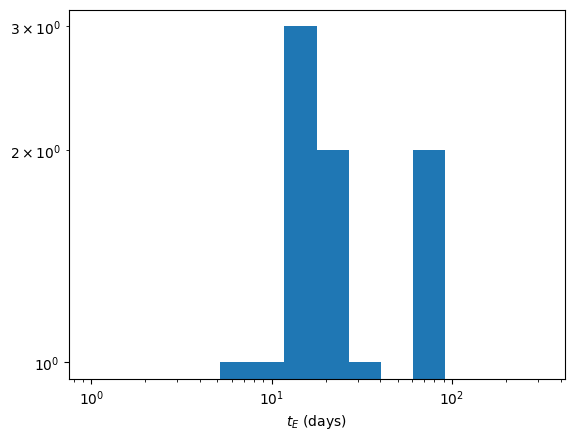

In [166]:
plt.hist(t['t_E'], bins = np.logspace(0, 2.5, 15))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')
plt.show()

## piE vs tE

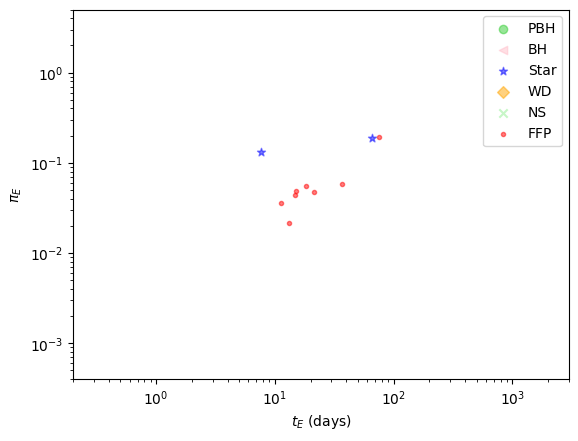

In [167]:
plt.scatter(t['t_E'][pbh_idx], t['pi_E'][pbh_idx], color = 'limegreen', marker='o', label = 'PBH', alpha=0.5)
plt.scatter(t['t_E'][bh_idx], t['pi_E'][bh_idx], color = 'pink', marker='<', label = 'BH', alpha=0.5)
plt.scatter(t['t_E'][st_idx], t['pi_E'][st_idx], color = 'blue', marker='*', label = 'Star', alpha=0.5)
plt.scatter(t['t_E'][wd_idx], t['pi_E'][wd_idx], color = 'orange', marker='D', label = 'WD', alpha=0.5)
plt.scatter(t['t_E'][ns_idx], t['pi_E'][ns_idx], color = 'lightgreen', marker='x', label = 'NS', alpha=0.5)
plt.scatter(t['t_E'][ffp_idx], t['pi_E'][ffp_idx], color = 'red', marker='.', label = 'FFP', alpha=0.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')
plt.ylabel('$\pi_E$')
plt.xlim(2e-1, 3e3)
plt.ylim(4e-4, 5e0)
plt.legend()
plt.show()

## dL vs dS

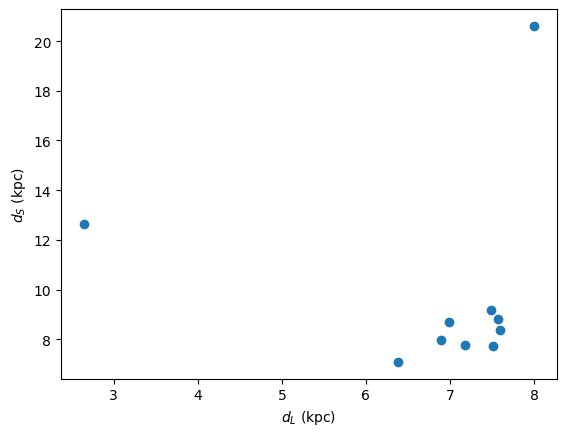

In [168]:
plt.scatter(t['rad_L'], t['rad_S'])
plt.xlabel('$d_L$ (kpc)')
plt.ylabel('$d_S$ (kpc)')
plt.show()